In this notebook, our goal is to create a high-performance classifier to predict the successes of a bank's marketing campaign in convincing the recipient of the advertising to open an account. More specifically, we will be using Bayesian Hyperparameter Optimization via a Gaussian Process to tune a Neural Network, demonstrating its strength of greatly improving the computational efficiency of the whole process. The dataset is publicly available at : https://archive.ics.uci.edu/dataset/222/bank+marketing

In [1]:
#Standard Libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import RocCurveDisplay
from imblearn.over_sampling import SMOTE

# Baseline Models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

print("Done")

Done


# Exploratory Analysis and Pre-Processing

In [2]:
# Open the Dataframe
df = pd.read_csv("bank_full.csv", delimiter=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# Look at Dtypes and Nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
# Look at ranges for the numerical values
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [5]:
# Dummy Encode Categorical Variables

new_df = pd.get_dummies(df, columns=['marital','job','education','contact','poutcome','month','default','housing','loan','day_of_week'])
new_df

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,False,False,True,False,False,False,True,False,False,False
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,False,False,True,False,False,False,True,False,False,False
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,False,True,True,False,False,False,True,False,False,False
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,False,False,True,False,False,False,True,False,False,False
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,False,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,False,True,True,False,False,True,False,False,False,False
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,False,False,True,False,False,True,False,False,False,False
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,False,True,True,False,False,True,False,False,False,False
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,False,False,True,False,False,True,False,False,False,False


In [6]:
# Convert the Booleans to the proper Datatypes and remove unnecessary columns - See original dataset source for more info

new_df.replace({False: 0, True: 1}, inplace=True)
new_df['target'] = (new_df['y'] == 'yes')*1
new_df = new_df.drop(columns=['y','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'])
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   age                            41188 non-null  int64
 1   duration                       41188 non-null  int64
 2   campaign                       41188 non-null  int64
 3   pdays                          41188 non-null  int64
 4   previous                       41188 non-null  int64
 5   marital_divorced               41188 non-null  int64
 6   marital_married                41188 non-null  int64
 7   marital_single                 41188 non-null  int64
 8   marital_unknown                41188 non-null  int64
 9   job_admin.                     41188 non-null  int64
 10  job_blue-collar                41188 non-null  int64
 11  job_entrepreneur               41188 non-null  int64
 12  job_housemaid                  41188 non-null  int64
 13  job_management  

In [7]:
# There is an approximately 8-to-1 Class Imbalance which needs to be remedied
new_df['target'].value_counts()

target
0    36548
1     4640
Name: count, dtype: int64

We discover a large Class-Imbalance for our response variable, and decide to remedy it using the SMOTE technique.

In [8]:
# Divide the Feature Columns from the response column
X_col = new_df[new_df.columns.drop('target')]
Y_col = new_df[['target']]

In [9]:
# Resample to a much more reasonable 1-in-3 ratio
sm = SMOTE(random_state= 22, sampling_strategy=0.34)
X_res, Y_res = sm.fit_resample(X_col, Y_col)

In [10]:
# Scale the Features
Scaler = StandardScaler()
X_new = pd.DataFrame(Scaler.fit_transform(X_res), columns= X_res.columns)

In [11]:
# Combine to get the Final DataFrame
df = pd.concat([X_new, Y_res], axis= 1)
df

,age,duration,campaign,pdays,previous,marital_divorced,marital_married,marital_single,marital_unknown,job_admin.,...,housing_yes,loan_no,loan_unknown,loan_yes,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,target
0,1.449274,-0.141071,-0.546016,0.261917,-0.376023,-0.326584,0.877858,-0.604290,-0.04045,-0.545684,...,-0.978465,0.492177,-0.144082,-0.387824,-0.444669,2.140346,-0.475916,-0.455952,-0.456899,0
1,1.540433,-0.506536,-0.546016,0.261917,-0.376023,-0.326584,0.877858,-0.604290,-0.04045,-0.545684,...,-0.978465,0.492177,-0.144082,-0.387824,-0.444669,2.140346,-0.475916,-0.455952,-0.456899,0
2,-0.282742,-0.255278,-0.546016,0.261917,-0.376023,-0.326584,0.877858,-0.604290,-0.04045,-0.545684,...,1.022009,0.492177,-0.144082,-0.387824,-0.444669,2.140346,-0.475916,-0.455952,-0.456899,0
3,-0.009266,-0.500010,-0.546016,0.261917,-0.376023,-0.326584,0.877858,-0.604290,-0.04045,1.832561,...,-0.978465,0.492177,-0.144082,-0.387824,-0.444669,2.140346,-0.475916,-0.455952,-0.456899,0
4,1.449274,0.009031,-0.546016,0.261917,-0.376023,-0.326584,0.877858,-0.604290,-0.04045,-0.545684,...,-0.978465,-2.031789,-0.144082,2.578488,-0.444669,2.140346,-0.475916,-0.455952,-0.456899,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48969,0.720004,1.023849,2.903243,0.261917,-0.376023,-0.326584,-1.139136,-0.604290,-0.04045,-0.545684,...,-0.978465,-2.031789,-0.144082,-0.387824,-0.444669,-0.467214,-0.475916,-0.455952,-0.456899,1
48970,-0.920853,3.213376,-0.162765,0.261917,-0.376023,-0.326584,-1.139136,-0.604290,-0.04045,-0.545684,...,1.022009,-2.031789,-0.144082,-0.387824,-0.444669,-0.467214,-0.475916,-0.455952,-0.456899,1
48971,-0.829695,2.325818,0.220486,0.261917,-0.376023,-0.326584,-1.139136,1.654833,-0.04045,-0.545684,...,-0.978465,0.492177,-0.144082,-0.387824,-0.444669,-0.467214,-0.475916,-0.455952,-0.456899,1
48972,0.993480,3.787679,0.603737,0.261917,-0.376023,-0.326584,0.877858,-0.604290,-0.04045,-0.545684,...,-0.978465,0.492177,-0.144082,-0.387824,-0.444669,-0.467214,-0.475916,-0.455952,-0.456899,1


In [12]:
# Return the Columns for quick copy and paste below
df.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'marital_divorced',
       'marital_married', 'marital_single', 'marital_unknown', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'default_no', 'default_unknown', 'default_yes', 'housing_no',
       'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes'

In [13]:
# Split the Data

X_train, X_test, Y_train, Y_test = train_test_split(df
        [['age', 'duration', 'campaign', 'pdays', 'previous', 'marital_divorced',
       'marital_married', 'marital_single', 'marital_unknown', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'default_no', 'default_unknown', 'default_yes', 'housing_no',
       'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed']],

       df['target'] , test_size=0.25, random_state=22)

# Modeling Phase

We begin by training 3 popular models as a baseline to to compare to. These models are tuned using a traditional, exhaustive hyperparameter gridsearch as they are much faster-fitting. The metric by which we measure the strength of our classifiers will be AUC.

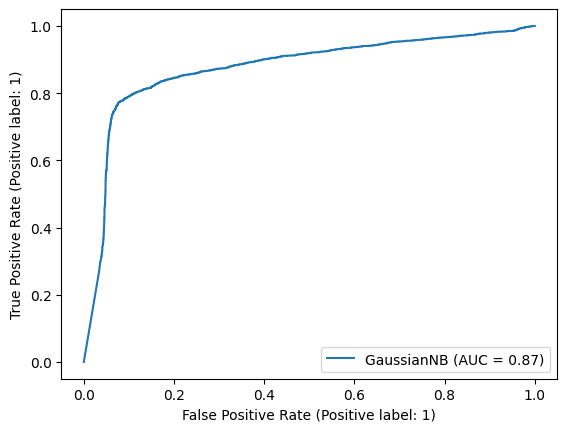

In [14]:
# Naive Bayes Baseline
NB = GaussianNB()
NB.fit(X_train,Y_train)
RocCurveDisplay.from_estimator(NB, X_test, Y_test)

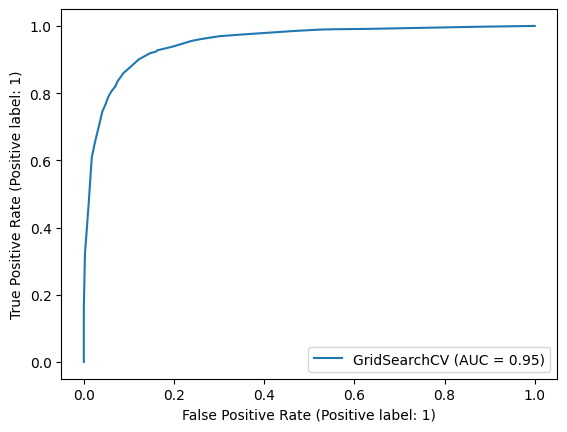

In [15]:
# Decison Tree Baseline
Cs = 10. ** np.arange(-3, 4)
tree_params = {'random_state': [22], 'ccp_alpha' : Cs.tolist()}
tree = GridSearchCV(DecisionTreeClassifier(), param_grid= tree_params)
tree.fit(X_train, Y_train)
RocCurveDisplay.from_estimator(tree,X_test,Y_test)

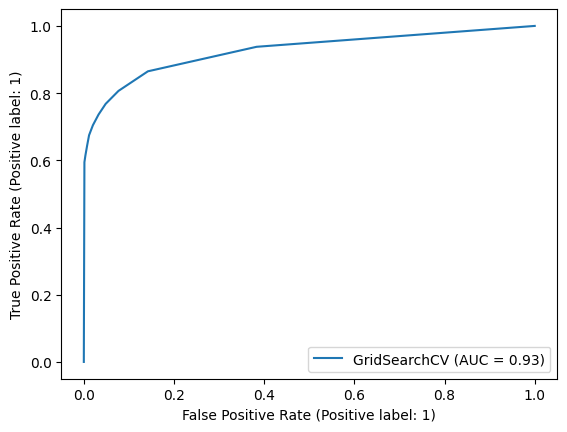

In [16]:
# Nearest-Neighbors Baseline

Neighbor_param_grid = {"n_neighbors": [1,2,3,5,10,20,50]}

KN = GridSearchCV(KNeighborsClassifier(),param_grid= Neighbor_param_grid)

KN.fit(X_train,Y_train)

RocCurveDisplay.from_estimator(KN, X_test, Y_test)

# Neural Network Model

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import logging
logging.disable(logging.WARNING)
import time
import statistics
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit,  StratifiedKFold

has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")



# Time String
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

Using device: cpu


In [18]:
# Conver Dtypes to Tensors
x_tensor = torch.FloatTensor(X_train.values).to(device)
y_tensor = torch.FloatTensor(Y_train.values).to(device)

In [19]:
'''
Dropout - The dropout percent for each layer.
NeuronPct - The percent of our maximum 5,000 neurons that we wish to use. This parameter specifies the total count of neurons in the entire network.
NeuronShrink - Neural networks usually start with more neurons on the first hidden layer and then decrease this count for additional layers.
This percent specifies how much to shrink subsequent layers based on the previous layer. We stop adding more layers once we run out of neurons (the count specified by NeuronPct).

'''
# A Dynamic Model Class

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, dropout, neuronPct, neuronShrink):
        super(NeuralNetwork, self).__init__()

        layers = []
        neuronCount = int(neuronPct * 5000)
        layer = 0

        prev_count = input_dim
        while neuronCount > 25 and layer < 10:
            layers.append(nn.Linear(prev_count, neuronCount))
            prev_count = neuronCount
            layers.append(nn.PReLU())
            layers.append(nn.Dropout(dropout))
            neuronCount = int(neuronCount * neuronShrink)
            layer += 1

        layers.append(nn.Linear(prev_count, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [20]:
# Print a random model to ensure things are working correctly

model = NeuralNetwork(X_train.values.shape[1], 0.2, 0.1, 0.25).to(device)
print(model)

NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=58, out_features=500, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=500, out_features=125, bias=True)
    (4): PReLU(num_parameters=1)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=125, out_features=31, bias=True)
    (7): PReLU(num_parameters=1)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=31, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [21]:
# Evaluation function for our Optimization Process - NLL (Negative-Log Likelihood)

SPLITS = 2
EPOCHS = 500
PATIENCE = 10

def evaluate_network(learning_rate=1e-3,dropout=0.2,
                        neuronPct=0.1, neuronShrink=0.25):

    boot = StratifiedShuffleSplit(n_splits=SPLITS, test_size=0.1)
    mean_benchmark = []
    epochs_needed = []

    for train, test in boot.split(X_train, Y_train):
        x_train = x_tensor[train]
        y_train = y_tensor[train]
        x_test = x_tensor[test]
        y_test = y_tensor[test]

        model = NeuralNetwork(X_train.values.shape[1],
                        dropout=dropout,
                        neuronPct=neuronPct,
                        neuronShrink=neuronShrink).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        dataset_train = TensorDataset(x_train, y_train)
        loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

        best_loss = float('inf')
        patience_counter = 0

        for epoch in range(EPOCHS):
            model.train()
            for batch_x, batch_y in loader_train:
                optimizer.zero_grad()
                outputs = model(batch_x)
                batch_y = batch_y.view(-1,1)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                outputs_test = model(x_test)
                y_test_reshaped = y_test.view(-1, 1)
                val_loss = criterion(outputs_test, y_test_reshaped).item()

            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= PATIENCE:
                epochs_needed.append(epoch)
                break

        # Evaluate
        with torch.no_grad():
            model.eval()
            # Move predictions to CPU for evaluation
            pred = model(x_test).cpu().numpy()
            y_compare = y_test.cpu().numpy()
            score = metrics.log_loss(y_compare, pred)
            mean_benchmark.append(score)

    return -statistics.mean(mean_benchmark)

# Ensure its working properly

print(evaluate_network(learning_rate=1e-3,
                       dropout=0.2,
                      neuronPct=0.1,
                      neuronShrink=0.25))

-0.18793435102376282


In [24]:
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [25]:
# Bounded region of parameter space
pbounds = {'dropout': (0.0, 0.499),
           'learning_rate': (0.0, 0.3),
           'neuronPct': (0.004, 0.1),
           'neuronShrink': (0.01, 1)
           }

optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=22,
)

start_time = time.time()
optimizer.maximize(init_points=10, n_iter=20,)
time_took = time.time() - start_time

print(f"Total runtime: {hms_string(time_took)}")
print(optimizer.max)

|   iter    |  target   |  dropout  | learni... | neuronPct | neuron... |
-------------------------------------------------------------------------
| 1         | -0.4545   | 0.2081    | 0.2161    | 0.004011  | 0.3093    |
| 2         | -3.674    | 0.07323   | 0.0277    | 0.02188   | 0.3521    |
| 3         | -4.032    | 0.198     | 0.1616    | 0.04424   | 0.6884    |
| 4         | -4.108    | 0.102     | 0.2634    | 0.006629  | 0.6738    |
| 5         | -4.206    | 0.2082    | 0.1676    | 0.01748   | 0.2061    |
| 6         | -4.032    | 0.3996    | 0.2905    | 0.03409   | 0.6954    |
| 7         | -4.032    | 0.4373    | 0.2684    | 0.01216   | 0.04866   |
| 8         | -4.032    | 0.08475   | 0.2634    | 0.01344   | 0.4269    |
| 9         | -7.971    | 0.478     | 0.1599    | 0.07042   | 0.3224    |
| 10        | -10.6     | 0.3426    | 0.2504    | 0.005756  | 0.7526    |
| 11        | -7.804    | 0.003852  | 0.04856   | 0.0721    | 0.7671    |
| 12        | -11.91    | 0.2208    | 

In [26]:
# Define the Bayesian- Optimised Model
model = NeuralNetwork(X_train.values.shape[1],0.13,0.02,0.65).to(device)
print(model)

NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=58, out_features=100, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Dropout(p=0.13, inplace=False)
    (3): Linear(in_features=100, out_features=65, bias=True)
    (4): PReLU(num_parameters=1)
    (5): Dropout(p=0.13, inplace=False)
    (6): Linear(in_features=65, out_features=42, bias=True)
    (7): PReLU(num_parameters=1)
    (8): Dropout(p=0.13, inplace=False)
    (9): Linear(in_features=42, out_features=27, bias=True)
    (10): PReLU(num_parameters=1)
    (11): Dropout(p=0.13, inplace=False)
    (12): Linear(in_features=27, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


In [27]:
# Defining Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr= 0.007)

In [ ]:
# Training

boot = StratifiedShuffleSplit(n_splits=SPLITS, test_size=0.1)
EPOCHS = 500
epoch = 0

for train, test in boot.split(X_train, Y_train):
  x_train = x_tensor[train]
  y_train = y_tensor[train]
  x_test = x_tensor[test]
  y_test = y_tensor[test]



dataset_train = TensorDataset(x_train, y_train)
loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)


while epoch < EPOCHS:
          epoch += 1
          model.train()
          for batch_x, batch_y in loader_train:
              optimizer.zero_grad()
              outputs = model(batch_x)
              batch_y = batch_y.view(-1,1)
              loss = criterion(outputs, batch_y)
              loss.backward()
              optimizer.step()

          model.eval()
          with torch.no_grad():
              outputs_test = model(x_test)
              y_test_reshaped = y_test.view(-1, 1)
              val_loss = criterion(outputs_test, y_test_reshaped).item()


In [ ]:
# Evaluate

with torch.no_grad():
 model.eval()
pred = model(x_test)


In [30]:
# Calculate AUC
from torchmetrics.classification import BinaryAUROC

Y_test_final = torch.FloatTensor(Y_test.values).to(device)
metric = BinaryAUROC(thresholds=None)
metric(pred, Y_test_final)


tensor([0.9857], dtype=torch.float64)

We find that the Neural Network achieves an AUC of 0.98 on the test set, outperforming all other models. Thanks to the Bayesian Hyperparameter tuning, this strong performance was achieved in a fraction of the time it would take for a traditional DNN workflow.